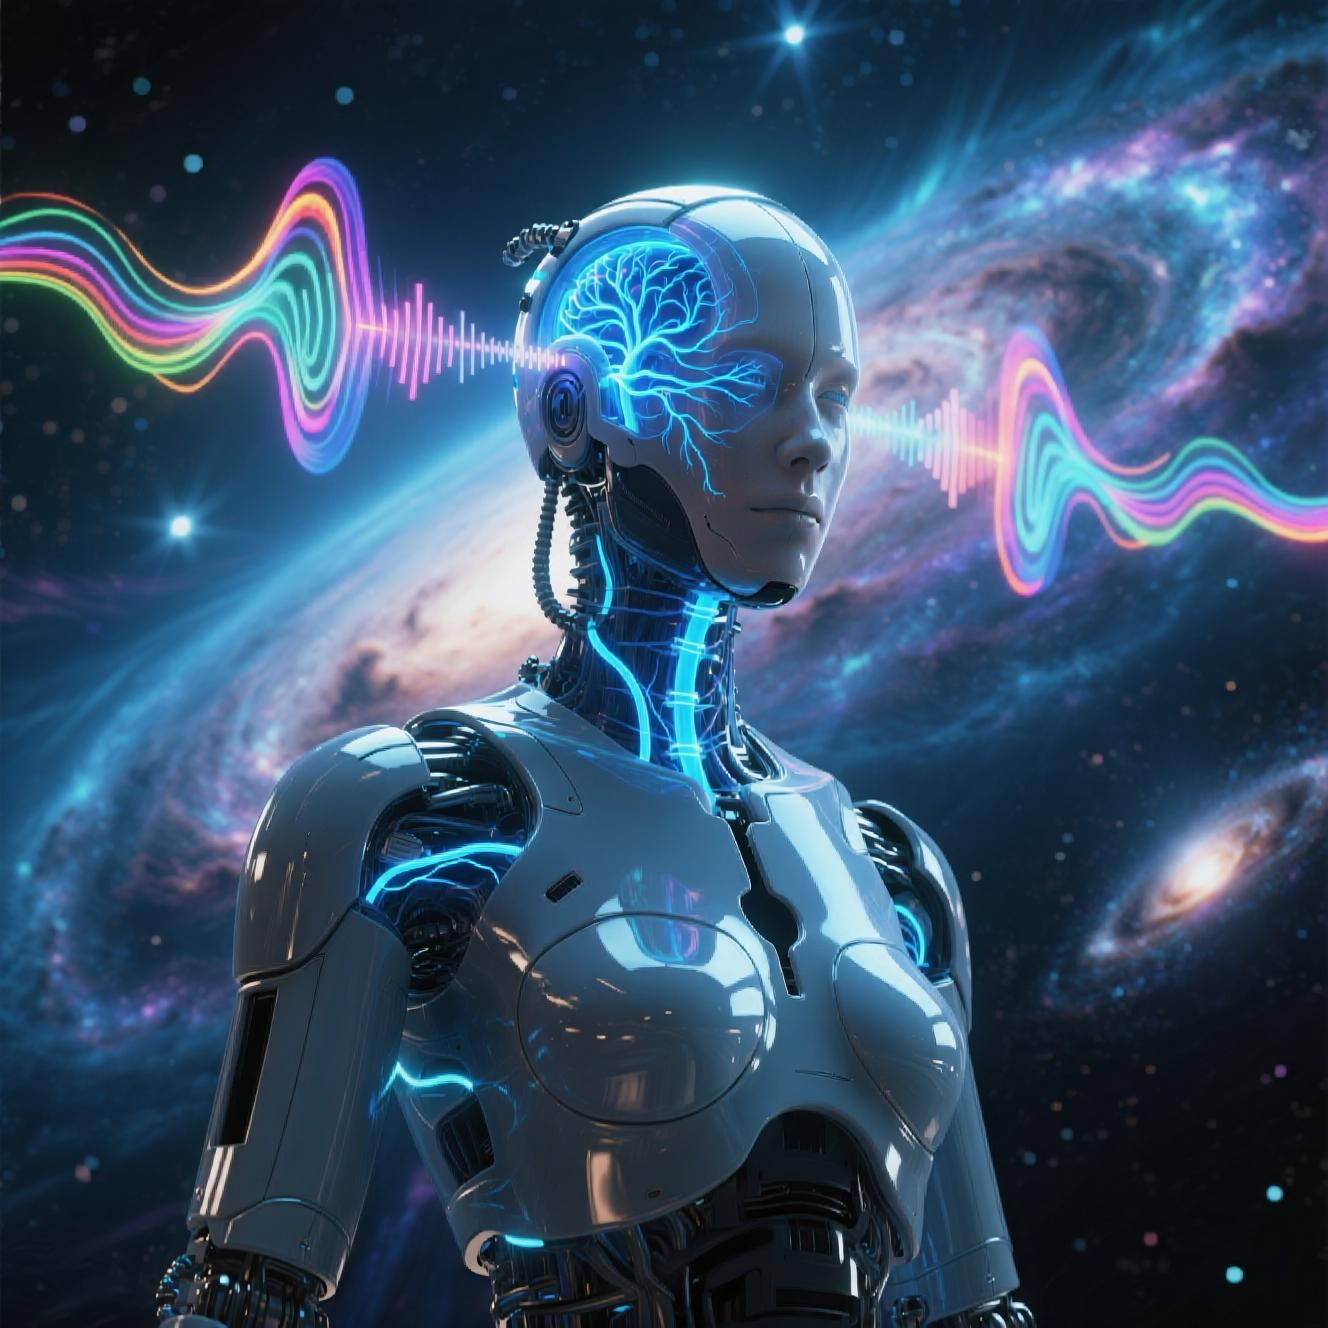

Emotion Detection from Speech Signals with Machine Learning

Emotion detection from speech signals, also known as Speech Emotion Recognition (SER), is a subfield of affective computing that aims to identify human emotional states from spoken language using machine learning and signal processing techniques. Emotions such as anger, happiness, sadness, fear, disgust, and neutrality are reflected in prosodic features of speech—including pitch, intensity, rhythm, and spectral characteristics—making it possible to model and classify them computationally.

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import kagglehub
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as ms
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import Audio
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import CategoricalCrossentropy

import warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

The following Python libraries and modules are utilized in the implementation of the proposed system. Pandas and NumPy are employed for data manipulation and numerical operations. Librosa is used for audio signal processing, including feature extraction such as Mel-frequency cepstral coefficients (MFCCs), while Matplotlib and Seaborn support data visualization. Missingno visualizes missing data patterns, and IPython.display enables audio playback within notebooks. Scikit-learn provides tools for preprocessing (StandardScaler, LabelEncoder, OneHotEncoder), model evaluation (accuracy_score, confusion_matrix, classification_report), and train-test splitting. Class imbalance is addressed using compute_class_weight. TensorFlow and Keras are used to build and train the deep learning model, which includes 1D convolutional, LSTM, and dense layers. The model incorporates regularization techniques such as dropout, batch normalization, and L2 regularization, optimized using Nadam and trained with categorical crossentropy loss. Callbacks such as EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint are implemented to enhance training stability and performance. KaggleHub facilitates dataset access, and TQDM provides progress tracking during processing. Warning messages are suppressed to ensure clean output during execution.

In [3]:
# CREMA-D dataset
path = kagglehub.dataset_download("ejlok1/cremad")
audio_dir = os.path.join(path, "AudioWAV")

print("Files:", len(os.listdir(audio_dir)))

Files: 7442


- **CREMA-D (Crowd-Sourced Emotional Multimodal Actors Dataset)**

It is a widely used audio-visual dataset designed for research in emotion recognition. It was developed by Cao, Mehta, Xiao, and Georgiou (2014) at the University of Southern California. The dataset consists of 7,442 video clips spoken by 91 professional actors of diverse ethnic backgrounds, aged 20–74 years, with both male and female representation.

The stimuli in CREMA-D are composed of 72 distinct sentences from the IEEE Harvard sentences and other neutral phrases, each recorded in one of six emotional categories: angry, disgusted, fearful, happy, neutral, and sad. These emotional expressions were elicited through standardized acting scripts and validated via crowd-sourced labeling, ensuring reliable emotional content.

Each recording is available in high-quality audio (16-bit, 48 kHz) and video format, making the dataset suitable for both unimodal (e.g., speech-based emotion recognition) and multimodal (audio-visual) analysis. The audio files are in WAV format and vary in duration, typically ranging from 1 to 5 seconds.

In [4]:
def parse(filename):
    parts = filename.split('_')
    return {'filename': filename, 'actor_id': parts[0], 'emotion': parts[2], 'intensity': parts[3]}

file_data = [parse(f) for f in os.listdir(audio_dir) if f.endswith('.wav')]
df = pd.DataFrame(file_data)

In [5]:
df.shape

(7442, 4)

Using "*.shape* " we can learn size of our  dataset (number of columns and rows)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   7442 non-null   object
 1   actor_id   7442 non-null   object
 2   emotion    7442 non-null   object
 3   intensity  7442 non-null   object
dtypes: object(4)
memory usage: 232.7+ KB


In [7]:
df.isnull().sum()

,0
filename,0
actor_id,0
emotion,0
intensity,0


Alternatively, we can use "*.isna().sum()* ", there is no difference between them.

Eventually, **we don't have any NULL values**.

<Axes: >

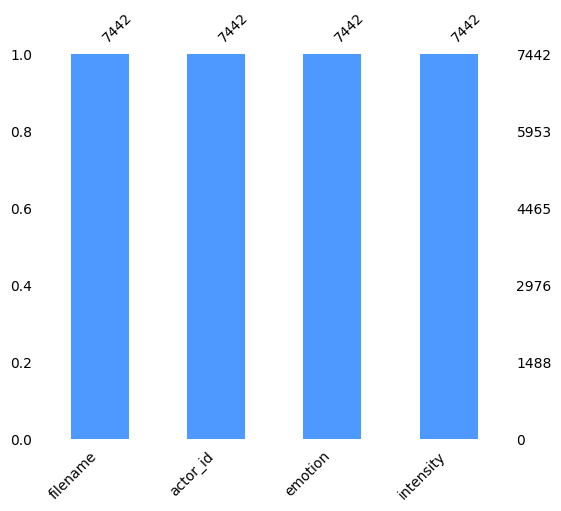

In [8]:
ms.bar(df, figsize = (6, 5), fontsize = 10, color = (0.3, 0.6, 1))

*missingo* is a Python library used to quickly visualize and understand missing data patterns in a dataset through heatmaps, dendograms, bar charts, matrix plots, and so forth.

In [9]:
print(df['emotion'].value_counts())

emotion
DIS    1271
HAP    1271
SAD    1271
FEA    1271
ANG    1271
NEU    1087
Name: count, dtype: int64


In [10]:
# Mapping

emotion_map = {'SAD': 'sad', 'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral'}
df['emotion_label'] = df['emotion'].map(emotion_map)

df['file_path'] = df['filename'].apply(lambda x: os.path.join(audio_dir, x))

df.head(10)

,filename,actor_id,emotion,intensity,emotion_label,file_path
0,1028_TSI_DIS_XX.wav,1028,DIS,XX.wav,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,1075_IEO_HAP_LO.wav,1075,HAP,LO.wav,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,1084_ITS_HAP_XX.wav,1084,HAP,XX.wav,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,1067_IWW_DIS_XX.wav,1067,DIS,XX.wav,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,1066_TIE_DIS_XX.wav,1066,DIS,XX.wav,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav
5,1027_DFA_DIS_XX.wav,1027,DIS,XX.wav,disgust,/kaggle/input/cremad/AudioWAV/1027_DFA_DIS_XX.wav
6,1032_IEO_HAP_HI.wav,1032,HAP,HI.wav,happy,/kaggle/input/cremad/AudioWAV/1032_IEO_HAP_HI.wav
7,1023_TIE_SAD_XX.wav,1023,SAD,XX.wav,sad,/kaggle/input/cremad/AudioWAV/1023_TIE_SAD_XX.wav
8,1041_TAI_DIS_XX.wav,1041,DIS,XX.wav,disgust,/kaggle/input/cremad/AudioWAV/1041_TAI_DIS_XX.wav
9,1004_WSI_SAD_XX.wav,1004,SAD,XX.wav,sad,/kaggle/input/cremad/AudioWAV/1004_WSI_SAD_XX.wav


The emotion labels in the dataset are standardized using a mapping that converts abbreviated codes (e.g., 'SAD', 'ANG') into full lowercase names (e.g., 'sad', 'angry') to ensure consistency and interpretability. A new column, emotion_label, is created to store these normalized labels. Additionally, the full file paths to the audio files are constructed by combining the directory path with each filename, stored in a new column file_path for easy access during audio loading. This preprocessing step organizes the data into a structured format suitable for emotion recognition modeling.

/tmp/ipython-input-4177444648.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df['emotion_label'], palette = 'magma')


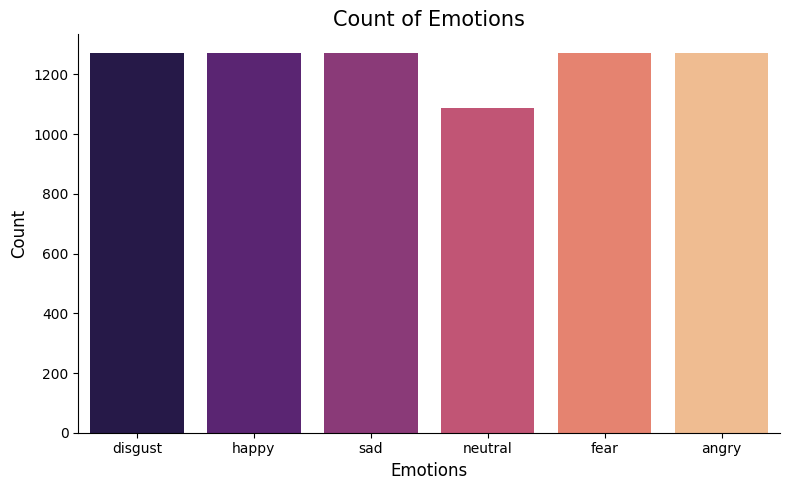

In [11]:
plt.figure(figsize = (8, 5))
plt.title('Count of Emotions', size = 15)
sns.countplot(x = df['emotion_label'], palette = 'magma')
plt.ylabel('Count', size = 12)
plt.xlabel('Emotions', size = 12)
sns.despine(top = True, right = True, left = False, bottom = False)
plt.tight_layout()
plt.show()

In [20]:
def waveplot(data, sr, emotion):
    plt.figure(figsize = (10, 3))
    librosa.display.waveshow(data, sr = sr, color = '#FF6F61')
    plt.title(f'{emotion}', size = 14, color = '#2A2A72')
    plt.xlabel("Time", color = '#555555')
    plt.ylabel("Amplitude", color = '#555555')
    plt.tight_layout()
    plt.show()

def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize = (10, 3))
    librosa.display.specshow(xdb, sr = sr, x_axis = 'time', y_axis = 'hz', cmap = 'viridis')
    cbar = plt.colorbar(format = '%+2.0f dB')
    cbar.set_label('Amplitude', rotation = 270, labelpad = 15, fontsize = 13, color = '#333333')
    plt.colorbar()
    plt.title(f'{emotion}', size = 14, fontweight = 'bold', color = '#2A2A72')
    plt.tight_layout()
    plt.show()

### **1) Waveform Plot**
A waveform plot visualizes the amplitude of an audio signal over time. It provides a time-domain representation of speech, showing variations in air pressure as a function of time. In emotion analysis, waveforms can reveal prosodic cues such as pauses, intensity changes, and speaking rate—features that often differ across emotional states. For example, angry speech typically exhibits higher amplitude and faster fluctuations, while sad speech may show lower energy and slower dynamics.

### **2) Spectrogram**
A spectrogram is a time-frequency representation of a signal, showing how the frequency content of speech evolves over time. It is computed using the Short-Time Fourier Transform (STFT) and displays frequency on the vertical axis, time on the horizontal axis, and intensity via color (e.g., amplitude in decibels). Spectrograms capture critical acoustic features such as pitch, formants, and spectral energy distribution, which are highly relevant for distinguishing emotions. For instance, fear may exhibit elevated pitch and broader frequency bands, while neutral speech tends to have more stable spectral patterns.

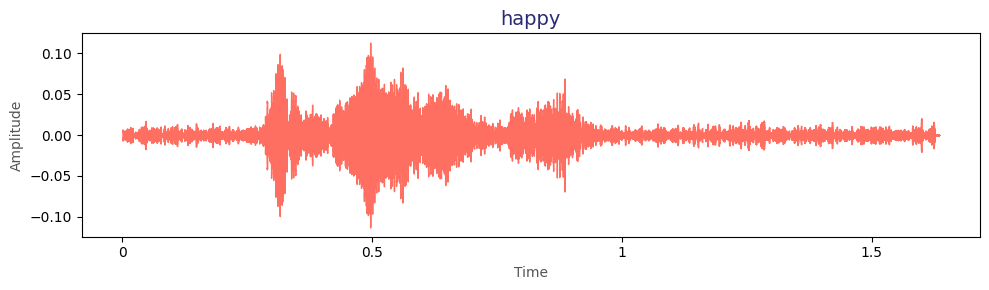

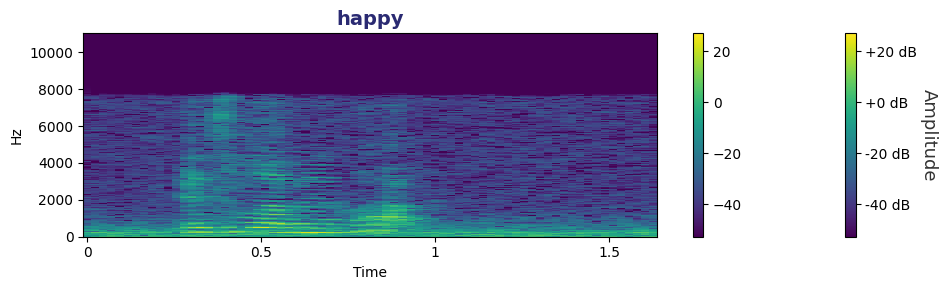

In [21]:
emotion = 'happy'

path = df[df['emotion_label'] == emotion]['file_path'].values[0]
data, sampling_rate = librosa.load(path)

# Plots
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

# Audio
Audio(path)

It visualizes and listens to a representative audio sample for a specific emotion. It retrieves the file path of the first audio clip labeled as "happy" from the dataset, loads the audio signal using Librosa, and then generates a waveform plot showing amplitude over time, and a spectrogram displaying the time-frequency characteristics of the speech signal.

Emotion: disgust


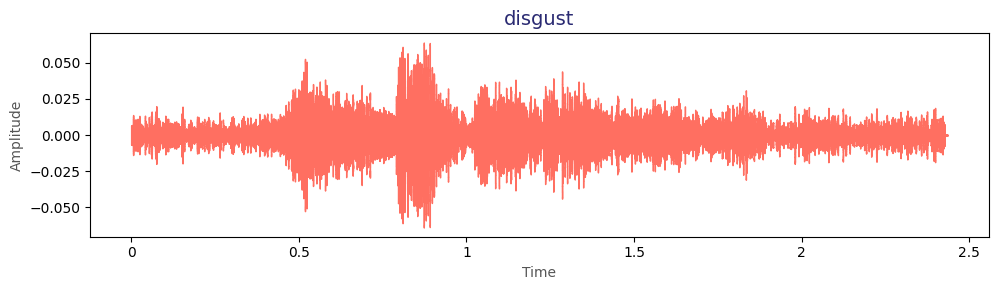

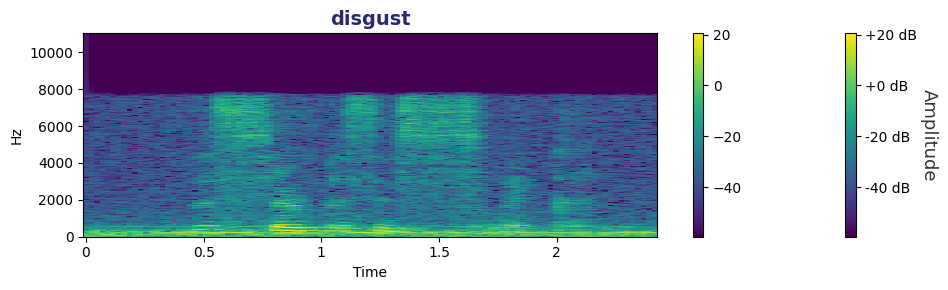

Emotion: happy


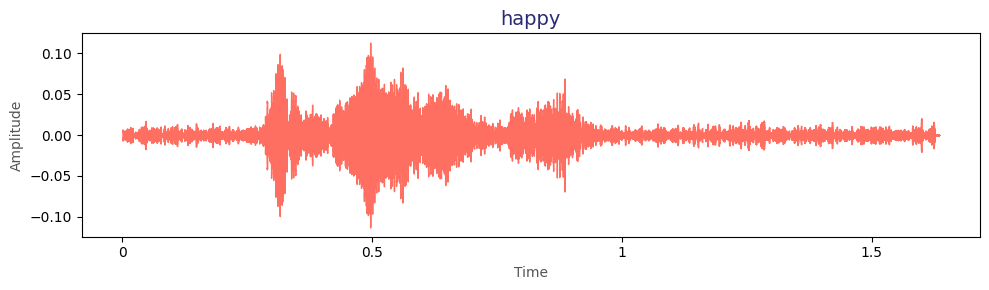

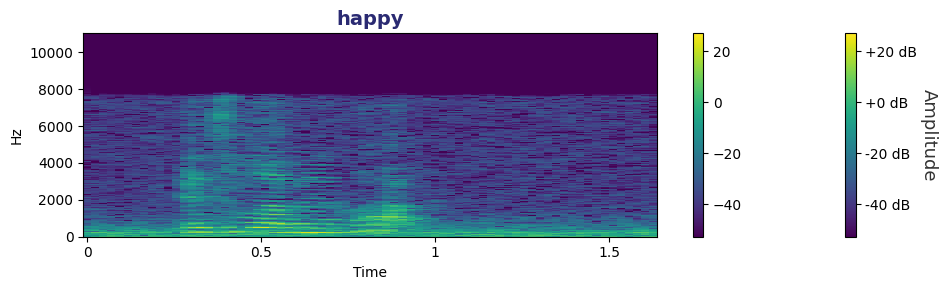

Emotion: sad


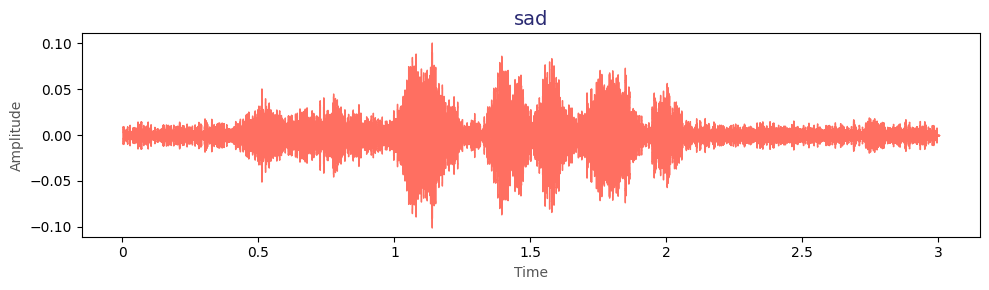

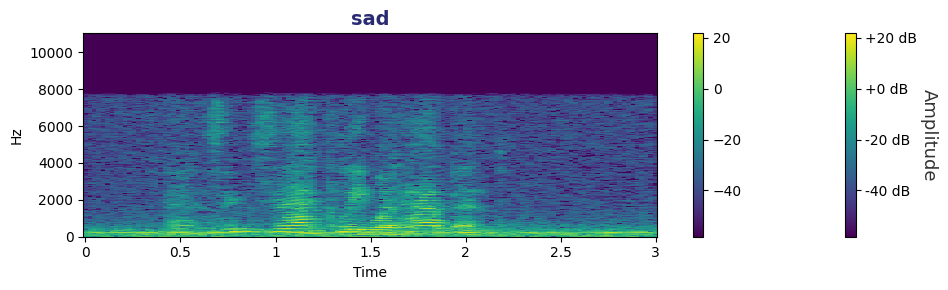

Emotion: neutral


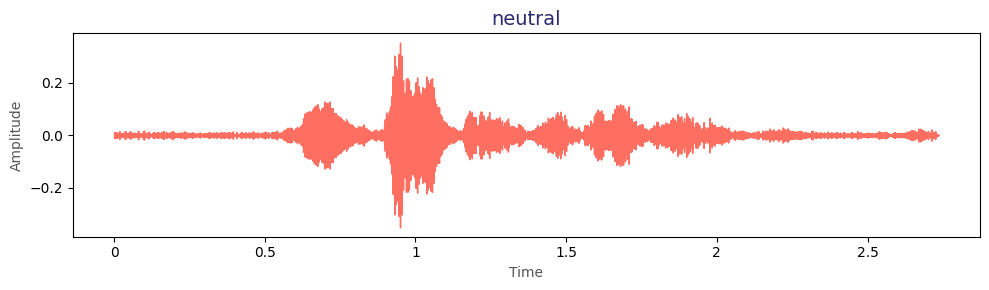

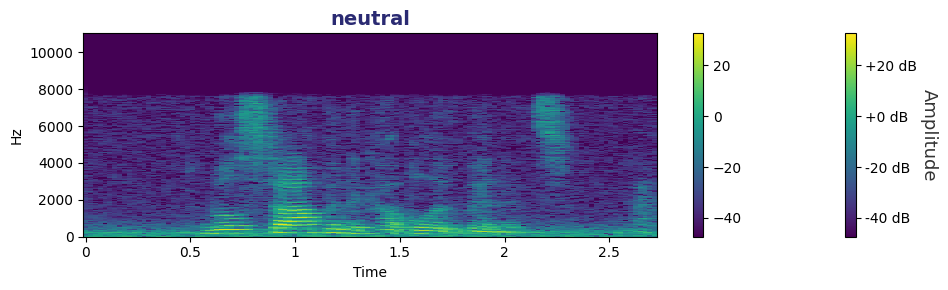

Emotion: fear


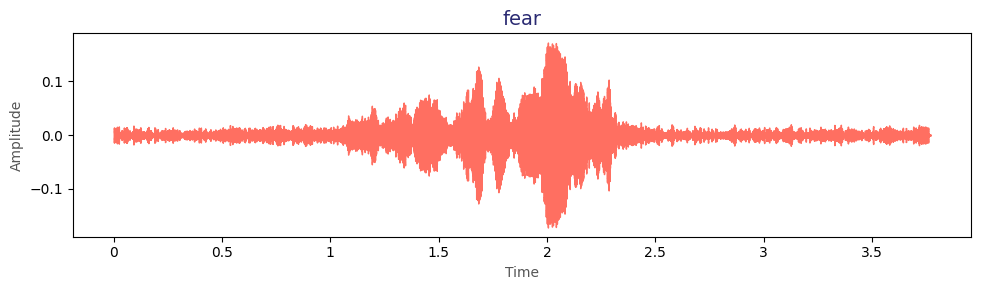

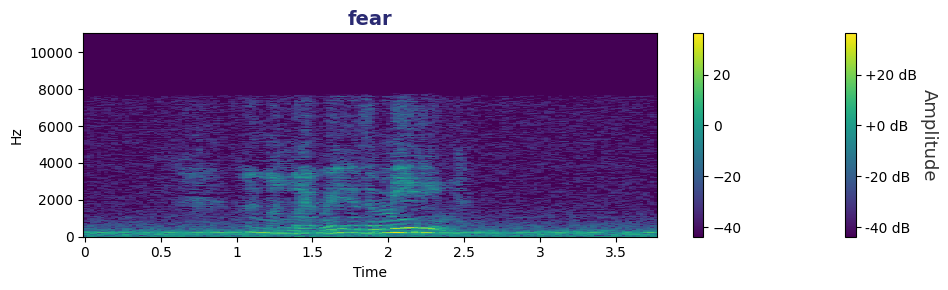

Emotion: angry


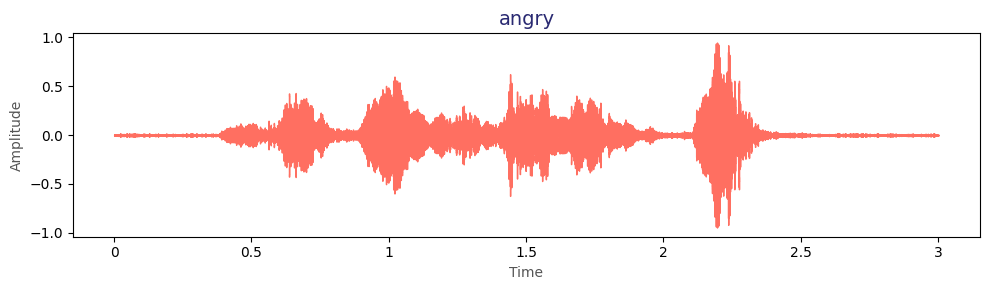

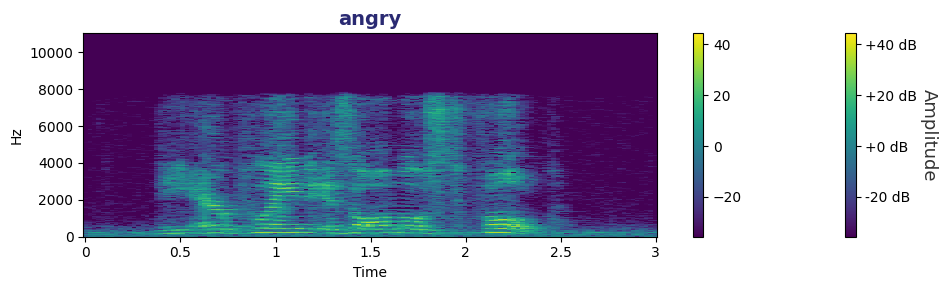

In [22]:
for emotion in ['disgust', 'happy', 'sad', 'neutral', 'fear', 'angry']:

    path = df[df['emotion_label'] == emotion]['file_path'].values[0]
    data, sr = librosa.load(path)
    print(f"Emotion: {emotion}")

    waveplot(data, sr, emotion)
    spectrogram(data, sr, emotion)
    display(Audio(path))

In [15]:
valid_labels = ['disgust', 'happy', 'sad', 'neutral', 'fear', 'angry']
max_len = 300
x, y = [ ], [ ]

for _, row in tqdm(df.iterrows(), total = len(df)):
    try:
        label = row['emotion_label']
        if label not in valid_labels: continue

        signal, sr = librosa.load(row['file_path'], sr = 22050)
        signal = signal / (np.max(np.abs(signal)) + 1e-7)  # Normalize

        mfcc = librosa.feature.mfcc(y = signal, sr = sr, n_mfcc = 13).T
        chroma = librosa.feature.chroma_stft(y = signal, sr = sr).T
        mel = librosa.feature.melspectrogram(y = signal, sr = sr, n_mels = 128)
        mel_db = librosa.power_to_db(mel).T
        zcr = librosa.feature.zero_crossing_rate(y = signal).T


        def pad(x): return np.pad(x, ((0, max_len - x.shape[0]), (0, 0)), mode = 'constant') if x.shape[0] < max_len else x[:max_len, : ]

        mfcc = pad(mfcc)
        chroma = pad(chroma)
        mel_db = pad(mel_db)
        zcr = pad(zcr)

        combined = np.concatenate((mfcc, chroma, mel_db, zcr), axis = 1)
        x.append(combined)
        y.append(label)

    except Exception as e: print(f"{row['filename']}: {e}")

x, y = np.array(x), np.array(y)

 90%|████████▉ | 6672/7442 [06:12<00:40, 18.96it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 7442/7442 [06:56<00:00, 17.86it/s]


The code preprocesses audio data for speech emotion recognition by extracting and combining multiple acoustic features from each audio file. Only samples with emotion labels in the predefined set—disgust, happy, sad, neutral, fear, and angry—are retained. For each valid audio file, the signal is loaded and normalized to ensure consistent amplitude scaling.

1. MFCCs (Mel-frequency cepstral coefficients): capture vocal timbre and phonetic content,
2. Chroma features: represent pitch class distribution,
3. Mel-spectrogram (in dB): reflects perceptually relevant spectral energy,
4. Zero-crossing rate (ZCR): indicates signal noisiness and rhythm.

Since audio files vary in length, all feature sequences are standardized to a fixed length (300 frames) using zero-padding or truncation. The features are then concatenated into a single time-series vector for each sample and stored in a list. After processing, the data is converted into NumPy arrays for input (x) and labels (y), forming the structured dataset used to train machine learning models. Lastly, this pipeline ensures uniform, robust, and emotion-discriminative input representation.

In [16]:
le = LabelEncoder()
y_le = le.fit_transform(y)
y_one = to_categorical(y_le)

print(dict(zip(le.classes_, le.transform(le.classes_))))

{np.str_('angry'): np.int64(0), np.str_('disgust'): np.int64(1), np.str_('fear'): np.int64(2), np.str_('happy'): np.int64(3), np.str_('neutral'): np.int64(4), np.str_('sad'): np.int64(5)}


### **1) LabelEncoder**

LabelEncoder is a utility from scikit-learn used to convert categorical labels into numerical format. It assigns a unique integer to each class (e.g., angry = 0). It is typically applied to the target variable in classification tasks. However, it introduces an implicit ordinal relationship between classes, which may mislead models into assuming one class is "greater" than another—making it less ideal for nominal categories.

### **2) OneHotEncoder**

OneHotEncoder transforms categorical variables into a binary one-hot vector representation, where each class is represented as a binary column. For example, three emotions (happy, sad, neutral) become three separate binary features. This avoids imposing any ordinal relationship and is preferred for training machine learning models, especially neural networks.

In [17]:
# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y_one, test_size = 0.2, random_state = 0, stratify = y_le)

# standardize
sc = StandardScaler()
x_train = sc.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = sc.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

x_train[0]

array([[-1.35873326,  1.19780978,  0.63266651, ..., -1.28885855,
        -1.28885461, -0.20555798],
       [-1.16440062,  1.26025165,  0.6944903 , ..., -1.28885855,
        -1.28885461, -0.07642664],
       [-1.21601771,  1.18162111,  0.79187101, ..., -1.28885855,
        -1.28885461,  0.05270471],
       ...,
       [ 0.67939984, -0.72949792, -0.12402215, ...,  0.75932302,
         0.75932325, -0.47375385],
       [ 0.67939984, -0.72949792, -0.12402215, ...,  0.75932302,
         0.75932325, -0.47375385],
       [ 0.67939984, -0.72949792, -0.12402215, ...,  0.75932302,
         0.75932325, -0.47375385]])

### **1) Stratify**

Stratification refers to a method used during data splitting (e.g., in train-test splits or cross-validation) to ensure that the proportion of classes in the target variable is preserved across all subsets. In the context of our dataset for fraud detection, where the target variable "Class" is highly imbalanced (approximately 0.17% fraud cases, Class=1, and 99.83% non-fraud cases, Class=0), stratification plays a crucial role to maintain representative class distributions in both training and test sets.

In fact, without stratification, random splitting could result in subsets with disproportionate class ratios, such as a training set with few or no fraud cases, leading to poor model learning, or a test set with an unrealistic number of frauds, yielding misleading performance metrics (e.g., precision, recall, F1 score). For that reason, it ensures that each subset reflects the original dataset’s class distribution, enabling the model (e.g., XGBoost in your project) to train effectively on fraud patterns and providing reliable evaluation metrics for imbalanced data.

In a nutshell, stratification ensures that both training and testing sets have the same class proportions as the original dataset which is crucial for imbalanced datasets like fraud detection.



### **2) Scaling**

Scaling in ML is all about getting your data to play nice together so your model doesn't trip over numbers that are on totally different scales like height in CMs say 180 and weight in KGs say 80 without scaling big numbers can bully smaller ones in algorithms like KNN, SVM or neural networks because they rely on distances or gradients scaling makes sure every feature gets an equal shot so your model learns better and faster its super important for stuff like gradient descent where big differences in scale can slow things down or mess up results plus it keeps things fair so no feature dominates just cause its numbers are bigger you dont always need scaling though like with decision trees or random forests since they don't care about scale but for most other models its a must.

Now, let's talk two big scaling methods **MinMaxScaler and Z-score** standardization a.k.a StandardScaler;

** *MinMaxScaler* ** takes your data and squashes it into a set range usually 0 to 1 it works by taking each value subtracting the smallest value in the feature and dividing by the range which is max minus min the formula is x scaled equals $X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}$* so if the heights are 170, 180, 190 the "min is 170",  "max is 190",  "range is 20". Thus,

* 180 => 180 minus 170 divided by 20 which is *0.5*
* 170 => 170 minus 170 divided by 20 which is *0.0*
* 190 => 190 minus 170 divided by 20 which is *1.0*

Eventually, this puts everything between 0 and 1 keeping the relative distances between values its great for models that like bounded data like NNs but watch out for outliers cause a crazy high or low value can squish everything else.

On the other hand, * **Z-score standardization or StandardScaler** * is different it makes your data have a mean of 0 and a standard deviation of 1 basically centering it around zero with a consistent spread the formula is, ($X_{\text{scaled}} = \frac{X - \mu}{\sigma}$). This method assumes your data is kinda normal bell curve ish and works awesome for algorithms like linear regression or SVM but outliers can mess with the mean and standard deviation so if your data’s wild you might need something else like RobustScaler.

* Mean: $\mu = \frac{180 + 170 + 190}{3} = 180$
* Std: $\sigma = \sqrt{\frac{(180-180)^2 + (170-180)^2 + (190-180)^2}{3}} = \sqrt{\frac{0 + 100 + 100}{3}} \approx 8$

Then;
* Z(180) => 180 minus 180 divided by 8 which is *0.0*
* Z(170) => 170 minus 180 divided by 8 which is *-1.2*
* Z(190) => 190 minus 180 divided by 8 which is *1.2*

Key points always scale after splitting your data into training and test sets to avoid data leakage where test info sneaks into training only fit your scaler on training data then use it to transform both training and test data MinMax is good for bounded ranges Z-score is better for normally distributed data if you got outliers RobustScaler might be your friend since it uses medians instead of means you can also reverse scaling to get back to original values which is handy for interpreting results.


In [18]:
model = Sequential()

model.add(Conv1D(32, kernel_size = 3, activation = 'relu', input_shape=(300, 154), kernel_regularizer = l2(1e-5)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.3))

# BiLSTM
model.add(Bidirectional(LSTM(32, return_sequences = False, kernel_regularizer = l2(1e-5))))

# Dense head
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation = 'softmax'))

# Compile
model.compile(optimizer = Nadam(learning_rate = 0.0005), loss = CategoricalCrossentropy(label_smoothing = 0.1), metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 298, 32)        │        14,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 298, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 149, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 149, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,862 (132.27 KB)

 Trainable params: 33,798 (132.02 KB)

 Non-trainable params: 64 (256.00 B)

The proposed model is a hybrid 1D Convolutional Neural Network (CNN) and Bidirectional LSTM architecture designed for speech emotion recognition. It takes fixed-length, multi-feature sequences as input.

The network begins with a Conv1D layer to extract local temporal patterns from the acoustic features, enhanced by Batch Normalization, MaxPooling, and Dropout for stability and regularization. This is followed by a Bidirectional LSTM layer, which captures long-term temporal dependencies in both forward and backward directions—critical for modeling dynamic prosodic cues in speech.

A fully connected Dense head with ReLU activation and dropout performs high-level reasoning, culminating in a 6-neuron softmax output layer for multiclass emotion classification.

The model is compiled using the Nadam optimizer for faster convergence, with Categorical Crossentropy loss and label smoothing to improve generalization and reduce overfitting. The architecture balances feature extraction, sequence modeling, and regularization, making it well-suited for time-series emotion classification from speech.

In [19]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3,verbose = 1)


class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_le), y = y_le)
class_weights = dict(enumerate(class_weights))

history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 20, batch_size = 32,
    class_weight = class_weights, callbacks = [early_stop, reduce_lr], verbose = 1)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 36s 156ms/step - accuracy: 0.2532 - loss: 1.7290 - val_accuracy: 0.3647 - val_loss: 1.5980 - learning_rate: 5.0000e-04
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 0.3615 - loss: 1.6148 - val_accuracy: 0.3694 - val_loss: 1.5746 - learning_rate: 5.0000e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 33s 175ms/step - accuracy: 0.3711 - loss: 1.5870 - val_accuracy: 0.4103 - val_loss: 1.5257 - learning_rate: 5.0000e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 52s 232ms/step - accuracy: 0.3971 - loss: 1.5493 - val_accuracy: 0.4090 - val_loss: 1.5134 - learning_rate: 5.0000e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 71s 174ms/step - accuracy: 0.3873 - loss: 1.5564 - val_accuracy: 0.4083 - val_loss: 1.5031 - learning_rate: 5.0000e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 29s 157ms/step - accuracy: 0.3967 - loss: 1.5315 - val_accuracy: 0.4372 - val_loss: 1.4824 - learning_rate: 5.0000e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 39s 14

1. **EarlyStopping**  monitors validation loss and halts training if no improvement is observed for 5 consecutive epochs, preventing overfitting by restoring the best weights.

2. **ReduceLROnPlateau** reduces the learning rate by 50% (factor = 0.5) when validation loss plateaus for 3 epochs, enabling finer convergence near optimal minima.

Given the imbalanced distribution of emotion classes in the dataset, class weights are computed using compute_class_weight with the 'balanced' mode. This assigns higher weights to underrepresented classes, ensuring the model is not biased toward majority classes during training.

The model is trained for 20 epochs with a batch size of 32, using these class weights and callbacks to enhance performance. Validation on a hold-out set guides early stopping and learning rate adaptation, promoting robust learning while minimizing overfitting. This strategy is essential for reliable speech emotion recognition under real-world data imbalances.

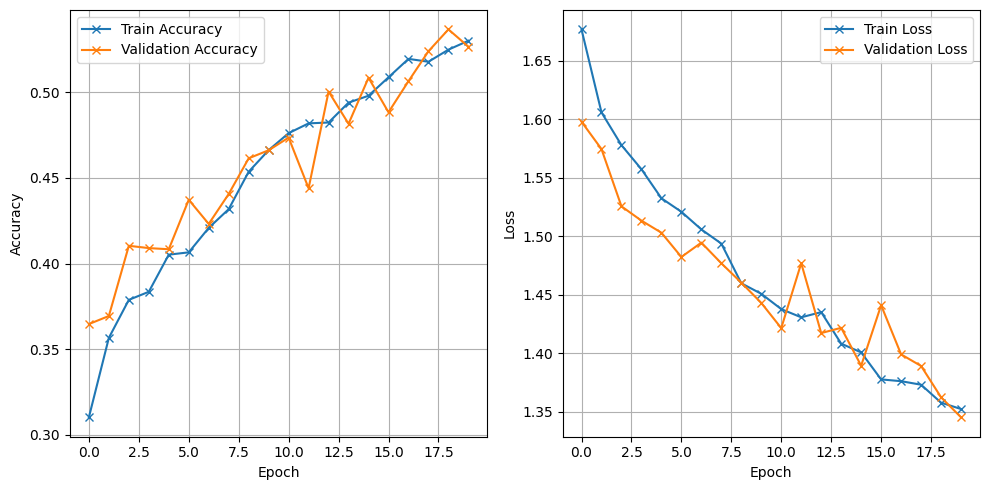

In [23]:
# Accuracy plot
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'Train Accuracy', marker = 'x')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', marker = 'x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Train Loss', marker = 'x')
plt.plot(history.history['val_loss'], label = 'Validation Loss', marker = 'x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

This visualization presents the training and validation performance of the model across epochs. The accuracy plot shows the progression of both training and validation accuracy, indicating how well the model learns and generalizes over time. The loss plot displays the corresponding training and validation loss, helping to identify trends such as overfitting, underfitting, or effective convergence.

In [24]:
pred_probs = model.predict(x_test)

pred = np.argmax(pred_probs, axis = 1)
actual = np.argmax(y_test, axis = 1)

# Accuracy
acs = accuracy_score(actual, pred)
print(f"Accuracy: {acs:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Accuracy: 0.53


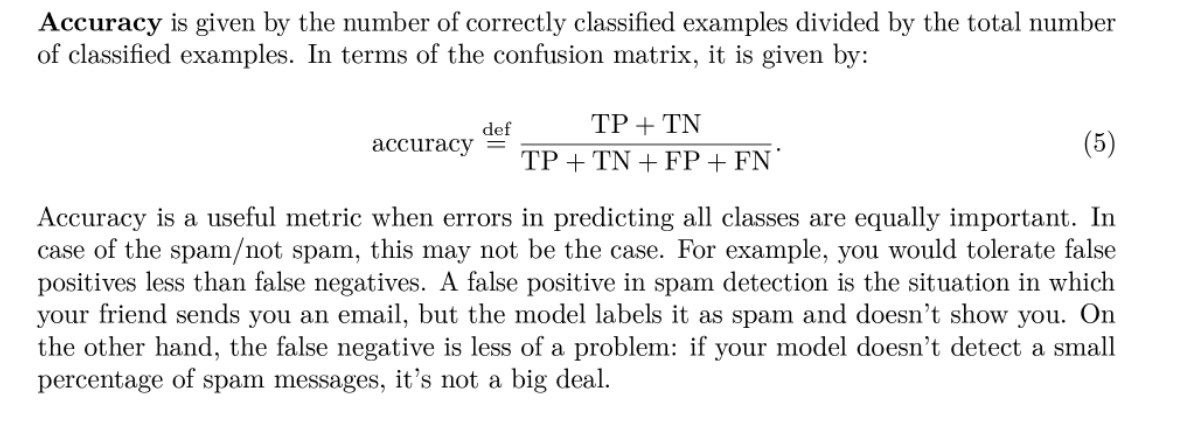

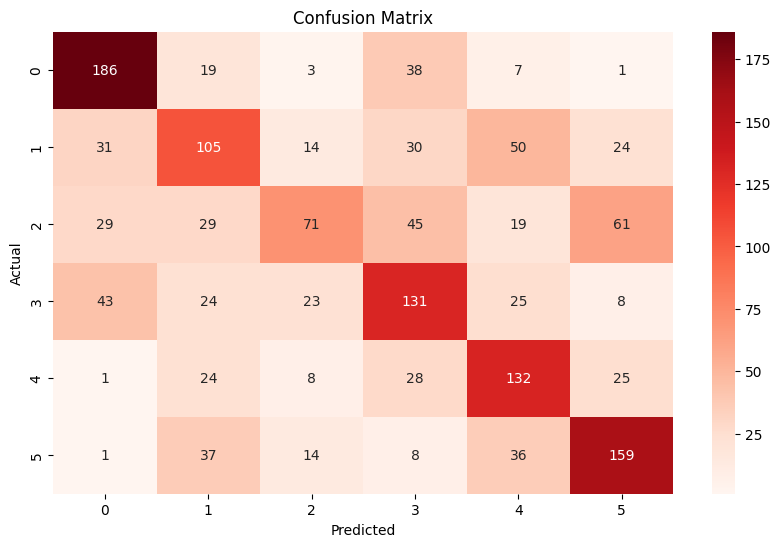

In [26]:
# Confusion Matrix

cm = confusion_matrix(actual, pred)
plt.figure(figsize = (10, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

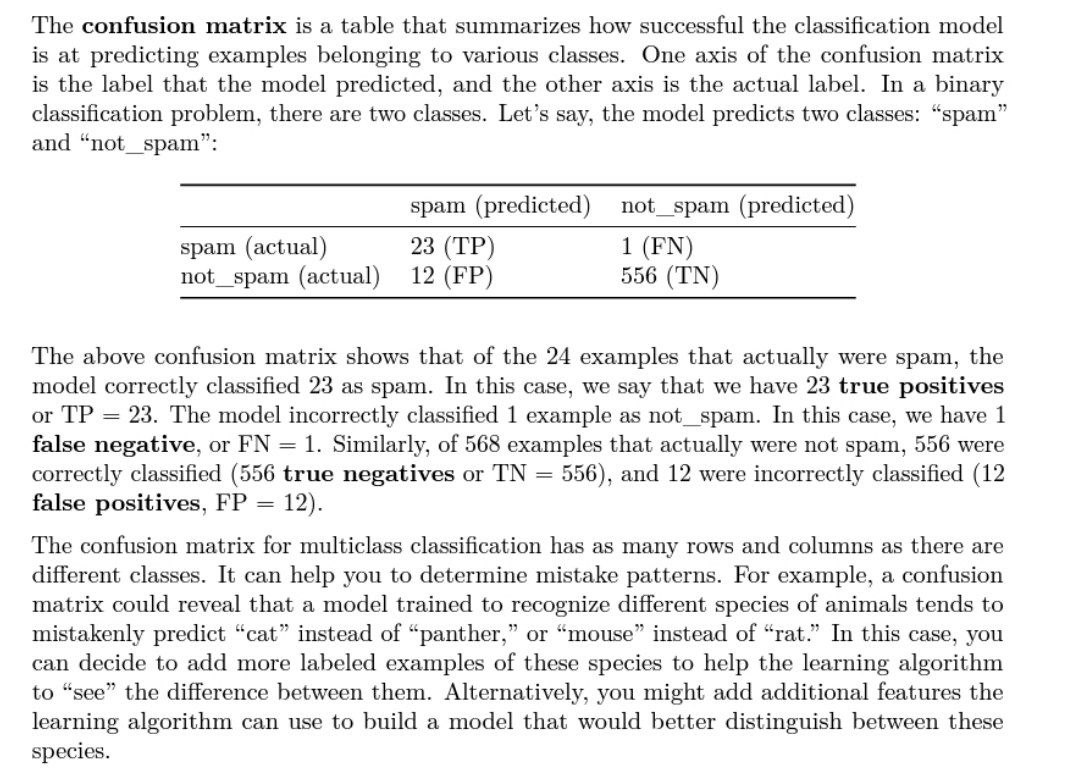

In [27]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.64      0.73      0.68       254
           1       0.44      0.41      0.43       254
           2       0.53      0.28      0.37       254
           3       0.47      0.52      0.49       254
           4       0.49      0.61      0.54       218
           5       0.57      0.62      0.60       255

    accuracy                           0.53      1489
   macro avg       0.52      0.53      0.52      1489
weighted avg       0.52      0.53      0.52      1489



A classification report is a comprehensive evaluation tool used to assess the performance of a classification model for each class in a multi-class problem. It provides key metrics including precision, recall (sensitivity), and F1-score, along with support (the number of actual instances per class).

1. Precision: The ratio of correctly predicted positive instances to the total predicted positives. It measures the model’s accuracy in classifying a given class.
2. Recall (Sensitivity): The ratio of correctly predicted positive instances to all actual positives. It reflects the model’s ability to identify all relevant instances.
3. F1-score: The harmonic mean of precision and recall, providing a balanced measure, especially useful when class distributions are imbalanced.
4. Support: The number of actual occurrences of each class in the dataset, important for interpreting metric reliability per class.

In that case, it is particularly valuable because emotional categories often have varying levels of expressiveness and representation (e.g., anger may be easier to detect than disgust). It allows researchers to identify which emotions are well-recognized and which are frequently confused, guiding improvements in data balancing, feature extraction, or model design.

Enter a number between 0 and 1488: 457
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Probabilities:
angry: 0.82%
disgust: 5.74%
fear: 18.85%
happy: 1.57%
neutral: 2.69%
sad: 70.34%


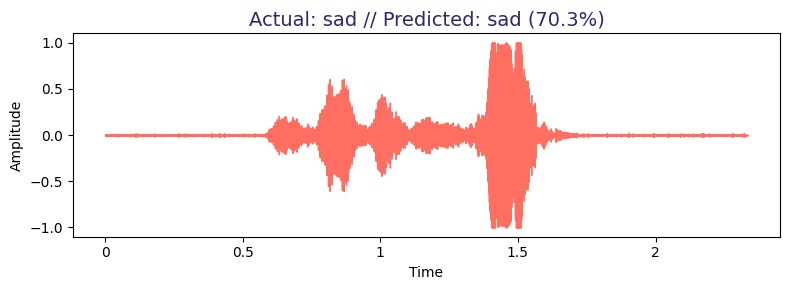

In [32]:
class_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
index_to_class = {v: k for k, v in class_mapping.items()}

# Sample index from test set
index = int(input(f"Enter a number between 0 and {len(x_test)-1}: "))
sample = np.expand_dims(x_test[index], axis = 0)

# Prediction
prediction = model.predict(sample)
predicted = index_to_class[np.argmax(prediction, axis = 1)[0]]
confidence = prediction[0].max() * 100

# Actual
label_index = y_test[index]
if isinstance(label_index, np.ndarray): label_index = np.argmax(label_index)
actual = index_to_class[label_index]

# Result

print("Probabilities:")
for i, prob in enumerate((prediction[0])): print(f"{index_to_class[i]}: {prob * 100:.2f}%")

# Waveplot

y, sr = librosa.load(df.iloc[index]['file_path'], sr = None)

plt.figure(figsize = (8, 3))
librosa.display.waveshow(y, sr = sr, color = '#FF6F61')
plt.title(f"Actual: {actual} // Predicted: {predicted} ({confidence:.1f}%)", fontsize = 14, color = '#2A2A72')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Audio

Audio(y, rate = sr)

This code implements an interactive model inference and visualization system to interpret the predictions of the trained speech emotion recognition model. It allows the user to select a sample from the test set and displays the model’s prediction alongside the true label, prediction confidence, and audio waveform.

A class mapping dictionary translates emotion labels into numerical indices (and vice versa), enabling conversion between model outputs (class indices) and human-readable labels. The selected test sample is passed through the model to obtain predicted class probabilities. The emotion with the highest probability is taken as the predicted label, and its confidence level is reported.

The classification probabilities for all 6 emotions are printed, offering insight into the model’s certainty and potential confusion between classes. Additionally, the corresponding waveform of the audio sample is plotted using Librosa, visually aligning the acoustic signal with the predicted and actual emotion. Finally, the audio is played back directly in the notebook, enabling auditory validation.

In [33]:
# Finally

*In conclusion, despite achieving a moderate accuracy of 53%, the model demonstrates the feasibility of using a hybrid CNN & BiLSTM architecture for speech emotion recognition on the CREMA-D dataset, highlighting the challenges of emotion classification due to inherent class imbalance, subjective labeling, and variability in speech patterns.*

***I WOULD LIKE TO EXPRESS MY SINCERE GRATITUDE FOR YOUR TIME AND CONSIDERATION***

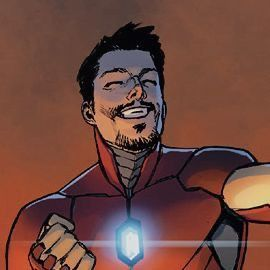